In [60]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from numpy.fft import fft, ifft, fftfreq
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

In [61]:
basepath = '/Users/yana/OneDrive - University of Wyoming/RESEARCH/BBC'
filefolders = '/Users/yana/OneDrive - University of Wyoming/RESEARCH/BBC/data'
baseline_path = '/Users/yana/OneDrive - University of Wyoming/RESEARCH/BBC/data/base/'

In [62]:
os.path.exists(baseline_path)


True

In [71]:
df = pd.DataFrame()
#sub_number = 0
#file = pd.read_csv(os.path.join(baseline_path, '20001', 'total_ts.csv'))
#time_column = file[['time']]
#df = pd.concat([df, time_column], axis = 1)

for filepath in glob.glob(os.path.join(baseline_path,'*/total_ts.csv')): 
    #print(filepath)
    file = pd.read_csv(filepath)
    #time_column = file[['time']]
    file = file[['Pu']]    
    sub_num = filepath.split('/')[-2]
    sub_num = sub_num[3:5]
    file.rename(columns = {'Pu':('sub-'+sub_num)}, inplace = True)
    df = pd.concat([df, file], axis = 1)

    print(sub_num)
    
file

#sub_number = [time, sub-01, sub-02, sub-03, sub-04, sub-08, sub-10] 

 #sub_number = sub_number + 1
    #data = file
    #df = pd.DataFrame(data, columns=['sub_'+str(sub_number)])
    
    
print(df)
    #file = file.transpose()

08
01
02
03
04
10
     sub-08    sub-01    sub-02    sub-03    sub-04    sub-10
0 -0.644472  1.797876 -0.815184 -0.376934  0.141275 -0.351786
1 -0.770741  0.639720 -0.549698 -0.860777  0.180017 -0.641288
2 -0.364052  0.355728 -0.087650 -0.734210 -0.298075 -0.208653
3 -0.148369  0.194052 -0.423381 -0.298679  0.415681 -0.127131
4 -0.041893 -0.128680  0.162000 -0.270529 -0.252525 -0.357007
5  0.163598 -0.166101  0.307607 -0.000120  0.130586 -0.079464
6  0.185239 -0.158817  0.257239  0.534270  0.021947 -0.132999
7  0.494937 -0.747150  0.288180  0.451536  0.203497  0.748300
8  0.292030 -0.880075  0.438539  0.821202 -0.374129  0.630110
9  0.833724 -0.906553  0.422347  0.734240 -0.168275  0.519918


In [84]:
def set_table(baseline_path, ROI):
    df = pd.DataFrame()
    for filepath in glob.glob(os.path.join(baseline_path,'*/total_ts.csv')): 
        #print(filepath)
        file = pd.read_csv(filepath)
        #time_column = file[['time']]
        file = file[[ROI]]    
        sub_num = filepath.split('/')[-2]
        sub_num = sub_num[3:5]
        file.rename(columns = {ROI:('sub-'+sub_num)}, inplace = True)
        df = pd.concat([df, file], axis = 1)
    return(df)

#sub_number = [time, sub-01, sub-02, sub-03, sub-04, sub-08, sub-10] 
#sub_number = sub_number + 1
    #data = file
    #df = pd.DataFrame(data, columns=['sub_'+str(sub_number)])         
    #file = file.transpose()

In [92]:
file = pd.read_csv(os.path.join(baseline_path, '20001', 'total_ts.csv'))
dfs_dict = {}
print(file.columns)
for col in file.columns:
    df = set_table(baseline_path, col)
    dfs_dict.update({col: df})
    
#print(df)
dfs_dict.pop('time')
dfs_dict.pop('SNr')
dfs_dict.pop('PBP')
dfs_dict.pop('VTA')
print(dfs_dict)
    #ROIs = {}
    #ROIs = ROIs.update(col)
    #print(ROIs)
    

Index(['time', 'Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'SNr',
       'PBP', 'VTA', 'VeP', 'HN', 'HTH', 'MN', 'STH', 'dlPFC', 'Viz', 'Hippo'],
      dtype='object')
{'Pu':      sub-08    sub-01    sub-02    sub-03    sub-04    sub-10
0 -0.644472  1.797876 -0.815184 -0.376934  0.141275 -0.351786
1 -0.770741  0.639720 -0.549698 -0.860777  0.180017 -0.641288
2 -0.364052  0.355728 -0.087650 -0.734210 -0.298075 -0.208653
3 -0.148369  0.194052 -0.423381 -0.298679  0.415681 -0.127131
4 -0.041893 -0.128680  0.162000 -0.270529 -0.252525 -0.357007
5  0.163598 -0.166101  0.307607 -0.000120  0.130586 -0.079464
6  0.185239 -0.158817  0.257239  0.534270  0.021947 -0.132999
7  0.494937 -0.747150  0.288180  0.451536  0.203497  0.748300
8  0.292030 -0.880075  0.438539  0.821202 -0.374129  0.630110
9  0.833724 -0.906553  0.422347  0.734240 -0.168275  0.519918, 'Ca':      sub-08    sub-01    sub-02    sub-03    sub-04    sub-10
0 -0.396878  1.352926 -0.694587 -1.279031 -0.162689 -0.474972
1 -

In [59]:
print(dfs_dict['Pu'])

     sub-08    sub-01    sub-02    sub-03    sub-04    sub-10
0 -0.644472  1.797876 -0.815184 -0.376934  0.141275 -0.351786
1 -0.770741  0.639720 -0.549698 -0.860777  0.180017 -0.641288
2 -0.364052  0.355728 -0.087650 -0.734210 -0.298075 -0.208653
3 -0.148369  0.194052 -0.423381 -0.298679  0.415681 -0.127131
4 -0.041893 -0.128680  0.162000 -0.270529 -0.252525 -0.357007
5  0.163598 -0.166101  0.307607 -0.000120  0.130586 -0.079464
6  0.185239 -0.158817  0.257239  0.534270  0.021947 -0.132999
7  0.494937 -0.747150  0.288180  0.451536  0.203497  0.748300
8  0.292030 -0.880075  0.438539  0.821202 -0.374129  0.630110
9  0.833724 -0.906553  0.422347  0.734240 -0.168275  0.519918


In [89]:
stats_circle = isc(dfs_dict["Hippo"], method='circle_shift', n_bootstraps=5000, return_bootstraps=True)

print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")


ISC: 0.054, p = 0.762


In [94]:
results_csh = {}
for ROI in dfs_dict:
    stats_circle = isc(dfs_dict[ROI], method='circle_shift', n_bootstraps=5000, return_bootstraps=True)
    results_csh.update({ROI: (f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")})
for key, value in results_csh.items():
    print(key, ' : ', value)
    #print(results_csh)
    

Pu  :  ISC: -0.23, p = 0.0276
Ca  :  ISC: 0.55, p = 0.0002
NAC  :  ISC: 0.34, p = 0.0036
EXA  :  ISC: -0.11, p = 0.439
GPe  :  ISC: -0.25, p = 0.015
GPi  :  ISC: 0.16, p = 0.0374
SNc  :  ISC: 0.39, p = 0.0002
RN  :  ISC: -0.087, p = 0.588
VeP  :  ISC: -0.039, p = 0.817
HN  :  ISC: 0.34, p = 0.0008
HTH  :  ISC: -0.049, p = 0.589
MN  :  ISC: -0.13, p = 0.244
STH  :  ISC: 0.25, p = 0.0142
dlPFC  :  ISC: -0.32, p = 0.0156
Viz  :  ISC: 0.59, p = 0.0002
Hippo  :  ISC: 0.054, p = 0.761


In [126]:
sub_timeseries = {}
for sub in glob.glob(os.path.join(baseline_path,'*/total_ts.csv')):
    sub_file = pd.read_csv(sub)
    sub_file.drop('time', inplace=True, axis=1)
    sub_file.drop('SNr', inplace=True, axis=1)
    sub_file.drop('PBP', inplace=True, axis=1)
    sub_file.drop('VTA', inplace=True, axis=1)
    sub_num = sub.split('/')[-2]
    sub_num = sub_num[3:5]
    sub_timeseries['sub-'+sub_num] = sub_file
print(sub_timeseries)

{'sub-08':          Pu        Ca       NAC       EXA       GPe       GPi       SNc  \
0 -0.644472 -0.396878  0.069003  0.357864  0.039225  0.176266  0.636133   
1 -0.770741 -0.760649 -0.587212 -0.142780 -0.438996 -0.298625  0.115965   
2 -0.364052 -0.169005  0.109330  0.329055  0.007882  0.096785  0.279523   
3 -0.148369  0.086435  0.112390  0.265816  0.055301  0.129043  0.146800   
4 -0.041893 -0.039339 -0.055038  0.014615 -0.134106 -0.090334 -0.030164   
5  0.163598  0.093120 -0.000118  0.029722 -0.000452 -0.019721 -0.153503   
6  0.185239 -0.002329 -0.036365 -0.428411 -0.087548 -0.107072 -0.250029   
7  0.494937  0.436035  0.190768 -0.216911  0.151160 -0.009190 -0.304995   
8  0.292030  0.159475  0.023341 -0.290690 -0.088730 -0.226017 -0.414928   
9  0.833724  0.593135  0.173900  0.081719  0.496265  0.348863 -0.024802   

         RN       VeP        HN       HTH        MN       STH     dlPFC  \
0  0.601056  0.348356 -0.853545  0.407728  0.476297  0.422410  0.094730   
1 -0.038608 -

Text(100.40000000000006, 0.5, 'ROI')

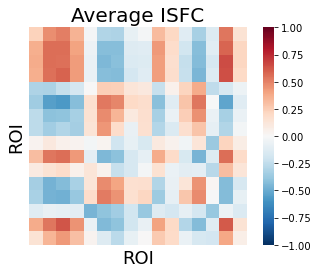

In [151]:
data = list(sub_timeseries.values())

isfc_output = isfc(data)

sns.heatmap(np.array(isfc_output).mean(axis=0), vmin=-1, vmax=1, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False)
plt.title('Average ISFC', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

#t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)

#print(t, p) 
#print(isfc_output)

[ 8.51595096e-01  2.36173578e+00  4.47598227e+00  1.78661984e+00
 -6.29447573e-02 -1.32286884e+00 -1.29072572e+00 -3.72421618e-01
 -1.14893041e-01  1.53233390e+00  9.41155701e-01 -6.23239229e-01
 -3.50259195e+00 -4.95977209e-01  4.17577148e+00  5.41991152e-01
  1.15167025e+00  2.50653691e+00  6.43901768e+00  1.54213899e+00
 -1.55204333e-01 -1.79295992e+00 -1.50434067e+00 -4.94788964e-01
 -4.90968637e-01  1.94170846e+00  6.62489236e-01 -8.57997555e-01
 -4.96961928e+00 -3.69053192e-01  3.80067769e+00  6.88364774e-01
  1.17289284e+00  2.36680460e+00  8.95417420e+00  1.65300632e+00
 -2.16737119e-01 -2.06155726e+00 -1.58577504e+00 -5.26129612e-01
 -6.01645644e-01  1.81270496e+00  6.10950033e-01 -1.31571932e+00
 -4.04339219e+00 -5.84454574e-01  4.72881973e+00  7.28893850e-01
  1.10576591e+00  2.17672433e+00  1.30268156e+01  1.68658887e+00
 -2.05978372e-01 -1.72430946e+00 -1.64274207e+00 -6.37425536e-01
 -5.19854982e-01  1.82615483e+00  6.86345555e-01 -1.19401967e+00
 -4.84939389e+00 -4.70325

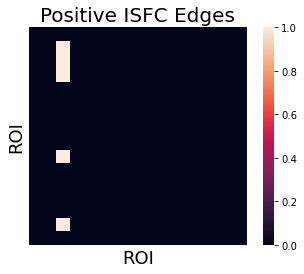

In [128]:

t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p, .05)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)
print(t, p)

In [ ]:
## CLAMP

In [136]:
clamp_path = '/Users/yana/OneDrive - University of Wyoming/RESEARCH/BBC/data/clamp/'

In [137]:
def clamp_set_table(clamp_path, ROI):
    clamp_df = pd.DataFrame()
    for clamp_filepath in glob.glob(os.path.join(clamp_path,'*/total_ts.csv')): 
        clamp_file = pd.read_csv(clamp_filepath)
        clamp_file = clamp_file.head(11)
        clamp_file = clamp_file[[ROI]]    
        clamp_sub_num = clamp_filepath.split('/')[-2]
        clamp_sub_num = clamp_sub_num[3:5]
        clamp_file.rename(columns = {ROI:('sub-'+clamp_sub_num)}, inplace = True)
        clamp_df = pd.concat([clamp_df, clamp_file], axis = 1)
    return(clamp_df)

In [142]:
clamp_file = pd.read_csv(os.path.join(clamp_path, '20001', 'total_ts.csv'))
clamp_dfs_dict = {}
print(clamp_file.columns)
for col in clamp_file.columns:
    clamp_df = clamp_set_table(clamp_path, col)
    clamp_dfs_dict.update({col: clamp_df})
    
#print(df)
clamp_dfs_dict.pop('time')
clamp_dfs_dict.pop('SNr')
clamp_dfs_dict.pop('PBP')
clamp_dfs_dict.pop('VTA')
clamp_dfs_dict.pop('HN')
clamp_dfs_dict.pop('insulin_uIU_mL')
clamp_dfs_dict.pop('glucose_mg_dL')

print(clamp_dfs_dict)

Index(['time', 'Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'SNr',
       'PBP', 'VTA', 'VeP', 'HN', 'HTH', 'MN', 'STH', 'dlPFC', 'Viz', 'Hippo',
       'insulin_uIU_mL', 'glucose_mg_dL'],
      dtype='object')
{'Pu':       sub-08    sub-01    sub-02    sub-03    sub-04    sub-10
0  -0.462672 -0.527702  0.948877 -0.511899  0.128556 -0.424372
1  -0.671698 -0.463110  0.958178 -0.645313 -0.285272 -0.328272
2  -0.583584 -0.167015  0.964012 -0.389220 -0.221755 -0.061232
3  -0.704805 -0.097958  0.744199 -0.564294 -0.461219 -0.269591
4  -0.672815 -0.370932  0.914570 -0.719149 -0.684054 -0.344374
5  -0.577133 -0.115137  0.882775 -0.553480 -1.082468 -0.302523
6  -0.083889 -0.357506  0.816895 -0.862412 -0.481171 -0.665496
7  -0.525306 -0.160600  0.764193 -0.685376 -0.146729 -0.554871
8  -0.745214 -0.313919  0.795457 -0.329117 -0.449406  0.388878
9  -0.910422 -0.345462  0.764816 -0.042348 -0.716743  0.760623
10 -0.898270 -0.279306  0.699239 -0.123117 -0.721624  0.750899, 'Ca':       sub-0

In [143]:
clamp_results_csh = {}
for ROI in clamp_dfs_dict:
    stats_circle = isc(clamp_dfs_dict[ROI], method='circle_shift', n_bootstraps=5000, return_bootstraps=True)
    clamp_results_csh.update({ROI: (f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")})
for key, value in clamp_results_csh.items():
    print(key, ' : ', value)
    #print(results_csh)

Pu  :  ISC: -0.22, p = 0.132
Ca  :  ISC: -0.00011, p = 1.0
NAC  :  ISC: 0.048, p = 0.845
EXA  :  ISC: 0.31, p = 0.0172
GPe  :  ISC: -0.089, p = 0.497
GPi  :  ISC: 0.37, p = 0.0098
SNc  :  ISC: -0.26, p = 0.0644
RN  :  ISC: 0.098, p = 0.477
VeP  :  ISC: -0.23, p = 0.177
HTH  :  ISC: 0.1, p = 0.381
MN  :  ISC: -0.15, p = 0.142
STH  :  ISC: -0.15, p = 0.367
dlPFC  :  ISC: -0.044, p = 0.702
Viz  :  ISC: 0.13, p = 0.257
Hippo  :  ISC: 0.036, p = 0.649


In [159]:
clamp_sub_timeseries = {}
for clamp_sub in glob.glob(os.path.join(clamp_path,'*/total_ts.csv')):
    clamp_sub_file = pd.read_csv(clamp_sub)
    clamp_sub_file = clamp_sub_file.head(11)
    clamp_sub_file.drop('time', inplace=True, axis=1)
    clamp_sub_file.drop('SNr', inplace=True, axis=1)
    clamp_sub_file.drop('PBP', inplace=True, axis=1)
    clamp_sub_file.drop('VTA', inplace=True, axis=1)
    clamp_sub_file.drop('HN', inplace=True, axis=1)
    clamp_sub_file.drop('insulin_uIU_mL', inplace=True, axis=1)
    clamp_sub_file.drop('glucose_mg_dL', inplace=True, axis=1)
    clamp_sub_num = clamp_sub.split('/')[-2]
    clamp_sub_num = clamp_sub_num[3:5]
    clamp_sub_timeseries['sub-'+clamp_sub_num] = clamp_sub_file
print(clamp_sub_timeseries)

{'sub-08':           Pu        Ca       NAC       EXA       GPe       GPi  SNc        RN  \
0  -0.462672 -0.869014  0.226368 -1.074743 -0.615625 -0.545462  0.0 -0.667037   
1  -0.671698 -0.920703  0.035798 -1.073833 -0.764601 -0.753423  0.0 -0.779403   
2  -0.583584 -0.850192  0.075293 -1.059046 -0.758427 -0.781183  0.0 -0.524688   
3  -0.704805 -0.991514 -0.009362 -1.026744 -0.804856 -0.841999  0.0 -0.661842   
4  -0.672815 -0.918455  0.003286 -0.992166 -0.870749 -0.850744  0.0 -0.501755   
5  -0.577133 -0.868534  0.218299 -0.709178 -0.673800 -0.750214  0.0 -0.268638   
6  -0.083889 -0.482225  0.977167 -0.186424  0.130369  0.041836  0.0  1.545461   
7  -0.525306 -0.616430  0.616976 -0.350439 -0.584972 -0.666211  0.0  0.198710   
8  -0.745214 -0.956105  0.218221 -0.737614 -0.840782 -0.965315  0.0 -0.437631   
9  -0.910422 -1.072262 -0.061583 -0.859317 -1.012780 -1.083738  0.0 -0.742517   
10 -0.898270 -0.994829  0.037349 -0.733974 -1.043818 -1.109893  0.0 -0.575676   

         VeP    

Text(100.40000000000006, 0.5, 'ROI')

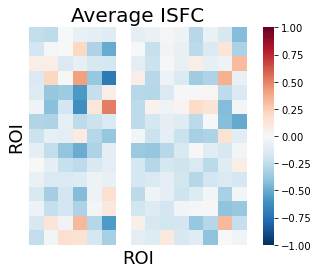

In [161]:
clamp_data = list(clamp_sub_timeseries.values())

clamp_isfc_output = isfc(clamp_data)

sns.heatmap(np.array(clamp_isfc_output).mean(axis=0), vmin=-1, vmax=1, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False)
plt.title('Average ISFC', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

#t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)

#print(t, p) 
#print(isfc_output)

[-1.42249838e+00 -1.69317957e+00 -1.48947023e-02 -4.41772019e-01
 -5.18492744e-01 -6.48812229e-01             nan -6.13543296e-01
 -3.11396826e-01 -1.29667265e-01 -4.58377492e-01 -1.90257036e+00
 -4.06685263e-01 -2.06455125e+00 -4.39757558e+00 -7.92572582e-01
 -1.60718874e-01 -1.77001170e-03  1.39657227e+00 -2.02777592e+00
 -4.63026979e+00             nan -4.06041097e-02 -8.37207585e-01
 -1.64060807e-01 -5.03728680e-01 -1.37039359e+00 -8.69218451e-01
  1.13456024e+00 -1.57667546e+00  3.38287089e-01  4.13752848e-01
 -1.02307340e+00 -5.22224938e-01 -8.55215414e-01 -1.13779584e+00
             nan -6.13460737e-01 -1.04392135e+00 -7.29441758e-02
 -5.88182909e-01  5.23938047e-01 -5.62630357e-01 -6.41439540e-01
  2.90887821e+00 -7.08095318e-01  1.57621097e+00  6.39897096e-03
  2.65986131e+00 -3.52868608e+00 -7.19402386e+00             nan
  4.78926129e-01 -1.04287616e+00 -2.22217733e-01 -7.90883743e-01
 -1.77725847e+00 -1.32140644e+00  2.84122606e+00 -3.34880137e-01
 -7.87515388e-01 -3.48976

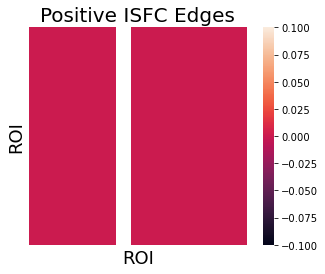

In [162]:

t, p = ttest_1samp(np.array([x.reshape(-1) for x in clamp_isfc_output]), 0)
thresh = fdr(p, .05)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, clamp_isfc_output[0].shape)

sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)
print(t, p)